In [1]:
import pandas as pd
import os
from scipy.sparse import csr_matrix, coo_matrix
import numpy as np
from IPython.display import display_html
import warnings
import random
import itertools

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
%matplotlib inline

from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
from lightfm import LightFM
from skopt import forest_minimize

from sklearn.utils import validation as skval
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")

pd.options.mode.chained_assignment = None  # default='warn'

/Users/timothyteh/opt/anaconda3/lib/python3.8/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [2]:
%%time
movies = pd.io.parsers.read_csv('./datasets/movies.dat', names=['movie_id', 'movie_name', 'rating'], engine='python', delimiter='::')
ratings = pd.io.parsers.read_csv('./datasets/ratings.dat', names=['user_id', 'movie_id', 'rating', 'time'], engine='python', delimiter='::')

CPU times: user 4.49 s, sys: 209 ms, total: 4.7 s
Wall time: 4.75 s


### EDA For Movies

In [3]:
movies.columns.values

array(['movie_id', 'movie_name', 'rating'], dtype=object)

In [4]:
movies.sample(2)

,movie_id,movie_name,rating
642,648,Mission: Impossible (1996),Action|Adventure|Mystery
2174,2243,Broadcast News (1987),Comedy|Drama|Romance


In [5]:
movies.shape

(3883, 3)

### Data Preprocessing for Movies

In [6]:
### One hot encoding of rating

# treat null values
movies['rating'].fillna('NA', inplace = True)

# separate all genres into one list, considering comma + space as separators
genre = movies['rating'].str.split('|').tolist()

# flatten the list
flat_genre = [item for sublist in genre for item in sublist]

# convert to a set to make unique
unique_genre = list(set(flat_genre))

In [7]:
# create columns by each unique genre
movies = movies.reindex(movies.columns.tolist() + unique_genre, axis=1, fill_value=0)

In [8]:
movies

,movie_id,movie_name,rating,Musical,Adventure,War,Film-Noir,Western,Comedy,Crime,...,Mystery,Animation,Horror,Sci-Fi,Documentary,Children's,Drama,Fantasy,Thriller,Romance
0,1,Toy Story (1995),Animation|Children's|Comedy,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children's|Fantasy,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3878,3948,Meet the Parents (2000),Comedy,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3879,3949,Requiem for a Dream (2000),Drama,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3880,3950,Tigerland (2000),Drama,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3881,3951,Two Family House (2000),Drama,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# for each value inside column, update the dummy
for index, row in movies.iterrows():
    for val in row['rating'].split('|'):
        if val != 'NA':
            movies.loc[index, val] = 1

In [10]:
movies.drop('rating', axis = 1, inplace = True)

In [11]:
movies

,movie_id,movie_name,Musical,Adventure,War,Film-Noir,Western,Comedy,Crime,Action,Mystery,Animation,Horror,Sci-Fi,Documentary,Children's,Drama,Fantasy,Thriller,Romance
0,1,Toy Story (1995),0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0
1,2,Jumanji (1995),0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3878,3948,Meet the Parents (2000),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3879,3949,Requiem for a Dream (2000),0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3880,3950,Tigerland (2000),0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3881,3951,Two Family House (2000),0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


### EDA for Ratings data

In [12]:
ratings.columns.values

array(['user_id', 'movie_id', 'rating', 'time'], dtype=object)

In [13]:
ratings.sample(5)

,user_id,movie_id,rating,time
904269,5468,39,5,959899039
476989,2928,3918,2,971551834
737233,4407,441,5,965155520
292152,1741,1639,4,974711456
286562,1712,3068,3,980388152


In [14]:
ratings.shape

(1000209, 4)

### Data Preprocessing for Ratings data

In [15]:
ratings.drop(['time'], axis=1)

,user_id,movie_id,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5
...,...,...,...
1000204,6040,1091,1
1000205,6040,1094,5
1000206,6040,562,5
1000207,6040,1096,4


In [16]:
ratings = ratings[ratings['user_id'].isin(random.sample(list(ratings['user_id'].unique()), k=2500))]

In [17]:
# computer average number of interactions per user
list_of_all_users_who_rated = list(ratings['user_id'])
ratings_dict = {}
for user in list_of_all_users_who_rated:
    if user not in ratings_dict.keys():
        ratings_dict[user] = 1
    else:
        ratings_dict[user] += 1
average_ratings_per_user = sum(ratings_dict.values()) / len(ratings_dict)
print("Average ratings per user: {}".format(average_ratings_per_user))

Average ratings per user: 172.6232


In [18]:
relevant_movie_ids = ratings['movie_id'].unique()
print(len(relevant_movie_ids))

3557


### Data Preprocessing: Conversion to Compressed Sparse Row (CSR) Matrix for Ratings data

In [19]:
user_movie_rating = pd.pivot_table(ratings, index='user_id', columns='movie_id', values='rating')

# fill missing values with 0
user_movie_rating = user_movie_rating.fillna(0)

user_movie_rating.head(10)

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,4.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0


In [20]:
len(user_movie_rating.index)

2500

In [21]:
user_movie_rating_csr = csr_matrix(user_movie_rating.values)
user_movie_rating_csr

<2500x3557 sparse matrix of type '<class 'numpy.float64'>'
	with 431558 stored elements in Compressed Sparse Row format>

In [22]:
user_id = list(user_movie_rating.index)
user_dict = {}
counter = 0 
for i in user_id:
    user_dict[i] = counter
    counter += 1

### Data Preprocessing: Conversion to Compressed Sparse Row (CSR) Matrix for Movies

In [23]:
movie_dict ={}
df = movies[['movie_id', 'movie_name']].sort_values('movie_id').reset_index()

for i in range(df.shape[0]):
    movie_dict[(df.loc[i,'movie_id'])] = df.loc[i,'movie_name']
    
relevant_movie_dict = {}
for i in relevant_movie_ids:
    relevant_movie_dict[i] = movie_dict[i]

In [24]:
movies2 = movies.loc[movies["movie_id"].isin(relevant_movie_dict)].set_index("movie_id")
movies2.drop('movie_name', axis = 1, inplace = True)
movies2

,Musical,Adventure,War,Film-Noir,Western,Comedy,Crime,Action,Mystery,Animation,Horror,Sci-Fi,Documentary,Children's,Drama,Fantasy,Thriller,Romance
movie_id,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3948,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3949,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3950,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [25]:
movies2.shape

(3557, 18)

In [26]:
movies_csr = csr_matrix(movies2.values)
movies_csr

<3557x18 sparse matrix of type '<class 'numpy.int64'>'
	with 6004 stored elements in Compressed Sparse Row format>

### Hyperparameter Tuning

In [27]:
train_interactions, test_interactions = random_train_test_split(user_movie_rating_csr, test_percentage=0.2)
train_interactions

<2500x3557 sparse matrix of type '<class 'numpy.float64'>'
	with 345246 stored elements in COOrdinate format>

In [28]:
train2, validation = random_train_test_split(train_interactions, test_percentage=0.2)

In [29]:
def sample_hyperparameters():
    """
    Yield possible hyperparameter choices.
    """
    while True:
        yield {
            "no_components": np.random.randint(16, 64),
            "learning_schedule": np.random.choice(["adagrad", "adadelta"]),
            "loss": np.random.choice(["bpr", "warp", "warp-kos"]),
            "learning_rate": np.random.exponential(0.05),
            "item_alpha": np.random.exponential(1e-8),
            "user_alpha": np.random.exponential(1e-8),
            "max_sampled": np.random.randint(5, 15),
            "num_epochs": np.random.randint(5, 50),
        }

In [30]:
num_samples_for_random_search = 10

In [31]:
def random_search_auc(train, item_features, num_samples=num_samples_for_random_search, num_threads=1, cv=5):
    """
    Sample random hyperparameters, fit a LightFM model, and evaluate it
    on the test set.
    Parameters
    ----------
    train: np.float32 coo_matrix of shape [n_users, n_items]
        Training data.
    test: np.float32 coo_matrix of shape [n_users, n_items]
        Test data.
    num_samples: int, optional
        Number of hyperparameter choices to evaluate.

    Returns
    -------
    generator of (auc_score, hyperparameter dict, fitted model)
    """
    for i in range(cv):
        train2, validation = random_train_test_split(train, test_percentage=0.2)
        for hyperparams in itertools.islice(sample_hyperparameters(), num_samples):
            num_epochs = hyperparams.pop("num_epochs")

            model = LightFM(**hyperparams)
            model.fit(train2, epochs=num_epochs,item_features=item_features, num_threads=num_threads)

            score = auc_score(model, validation, train_interactions=train2, item_features = item_features, num_threads=num_threads).mean()

            hyperparams["num_epochs"] = num_epochs

            yield (score, hyperparams, model)

In [32]:
### Best hyperparameters to maximise AUC score
(score_auc, hyperparams_auc, model) = max(random_search_auc(train=train_interactions, item_features = movies_csr, num_threads=1), key=lambda x: x[0])

print("Best AUC score {} \nHyperparameters: \n{}".format(score_auc, hyperparams_auc))

Best AUC score 0.710809051990509 
Hyperparameters: 
{'no_components': 62, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.039852393224741905, 'item_alpha': 9.34095252112953e-09, 'user_alpha': 2.2473653810828513e-09, 'max_sampled': 13, 'num_epochs': 10}


In [33]:
def random_search_precision_at_k(k, train, item_features, num_samples=num_samples_for_random_search, num_threads=1, cv=5):
    """
    Sample random hyperparameters, fit a LightFM model, and evaluate it
    on the test set.
    Parameters
    ----------
    train: np.float32 coo_matrix of shape [n_users, n_items]
        Training data.
    test: np.float32 coo_matrix of shape [n_users, n_items]
        Test data.
    num_samples: int, optional
        Number of hyperparameter choices to evaluate.

    Returns
    -------
    generator of (auc_score, hyperparameter dict, fitted model)
    """
    for i in range(cv):
        train2, validation = random_train_test_split(train, test_percentage=0.2)
        for hyperparams in itertools.islice(sample_hyperparameters(), num_samples):
            num_epochs = hyperparams.pop("num_epochs")

            model = LightFM(**hyperparams)
            model.fit(train2, epochs=num_epochs,item_features=item_features, num_threads=num_threads)

            score = precision_at_k(model, validation, train2, k=k, item_features=item_features, preserve_rows=False, num_threads=1, check_intersections=True).mean()

            hyperparams["num_epochs"] = num_epochs

            yield (score, hyperparams, model)


Best precision score at k=50: 0.034692395478487015
Precision scores at k=50: [0.045525257, 0.039923817, 0.035963647, 0.033001203, 0.031127507]

Best precision score at k=100: 0.030395159497857094
Precision scores at k=100: [0.046182837, 0.039923817, 0.035661586, 0.032700483, 0.030572575]

Best precision score at k=150: 0.02757575921714306
Precision scores at k=150: [0.045140333, 0.040048115, 0.036102645, 0.033181638, 0.030880513]

Best precision score at k=200: 0.025202810764312744
Precision scores at k=200: [0.044338413, 0.03903769, 0.035159048, 0.03264635, 0.030676823]

Best precision score at k=250: 0.02409963682293892
Precision scores at k=250: [0.045052122, 0.040252607, 0.0359583, 0.03323376, 0.031036083]

Best highest average precision: 0.03710828609764576 
Best k: 50 
Best hyperparams to maximise precision_at_k score: {'no_components': 17, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.07913947381509914, 'item_alpha': 1.8013900613998073e-08, 'user_alpha': 7.

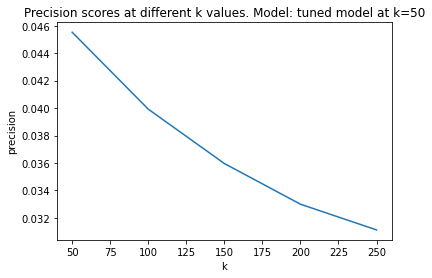

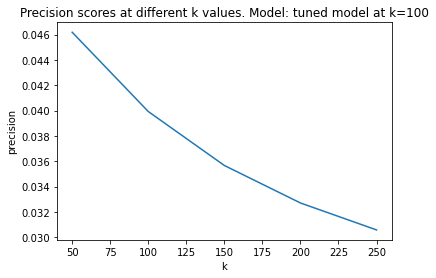

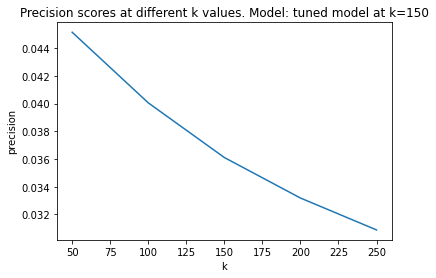

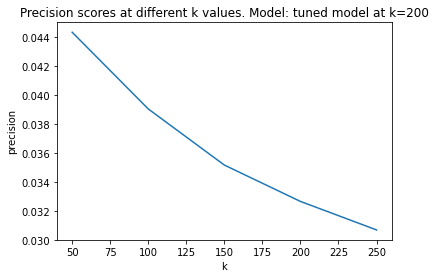

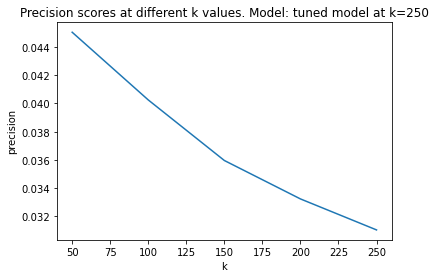

In [34]:
### Best hyperparameters to maximise precision_at_k score

# Experiment 1: large k-values
counter = 1
best_average_score_precision = 0
best_hyperparams_precision = None
best_model_precision = None
best_k = 0
for k in range(50, 251, 50):
    (score_precision, hyperparams_precision, model) = max(random_search_precision_at_k(k=k, train=train2, item_features = movies_csr, num_threads=1), key=lambda x: x[0])
    print("\nBest precision score at k={}: {}".format(k, score_precision))
    precision_score_array = []
    # After getting the best hyperparams for the model at a specific k, we see how its precision score changes as k changes
    for j in range(50, 251, 50):
        precision_score = precision_at_k(model, validation, train2, k=j, item_features=movies_csr, preserve_rows=False, num_threads=1, check_intersections=True).mean()
        precision_score_array.append(precision_score)
    ave_precision_score = sum(precision_score_array) / len(precision_score_array)
    if ave_precision_score > best_average_score_precision:
        best_average_score_precision = ave_precision_score
        best_hyperparams_precision = hyperparams_precision
        best_model_precision = model
        best_k = k
    print("Precision scores at k={}: {}".format(k, precision_score_array))
    plt.figure(counter)
    plt.plot(range(50, 251, 50), precision_score_array)
    plt.xlabel('k')
    plt.ylabel('precision')
    plt.title("Precision scores at different k values. Model: tuned model at k={}".format(k))
    plt.show
    counter+=1

print("\nBest highest average precision: {} \nBest k: {} \nBest hyperparams to maximise precision_at_k score: {}".format(best_average_score_precision, best_k, hyperparams_precision))


Best precision score at k=2: 0.04865299537777901
Precision scores at k=2: [0.05332799, 0.058340017, 0.057939053, 0.05513232, 0.05417001]

Best precision score at k=4: 0.04740859940648079
Precision scores at k=4: [0.061547715, 0.061347235, 0.05900829, 0.055783883, 0.055733763]

Best precision score at k=6: 0.04269029572606087
Precision scores at k=6: [0.054931838, 0.059943866, 0.057003476, 0.055834003, 0.054490775]

Best precision score at k=8: 0.042835671454668045
Precision scores at k=8: [0.05513232, 0.057538092, 0.05620155, 0.05513232, 0.053849246]

Best precision score at k=10: 0.041278135031461716
Precision scores at k=10: [0.056936648, 0.056234963, 0.05566694, 0.054881714, 0.05404972]

Best highest average precision: 0.05868417695164681 
Best k: 4 
Best hyperparams to maximise precision_at_k score: {'no_components': 48, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.0644213251309325, 'item_alpha': 9.53089077921685e-10, 'user_alpha': 6.803229155094675e-09, 'max

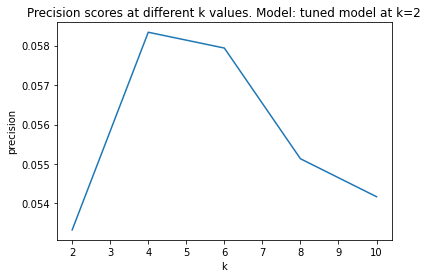

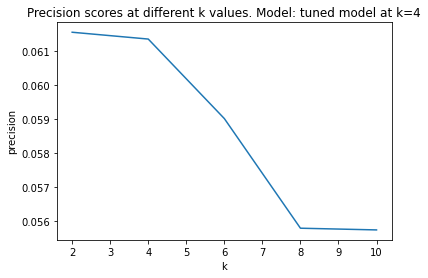

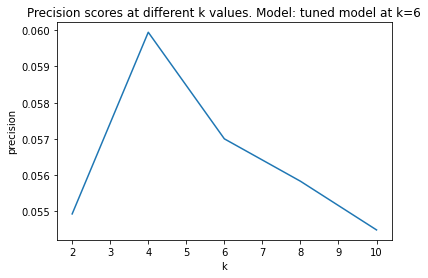

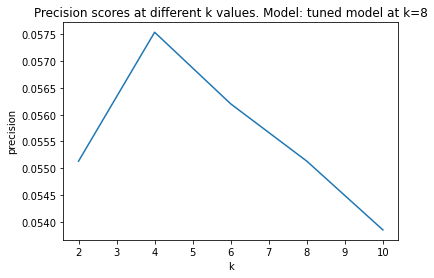

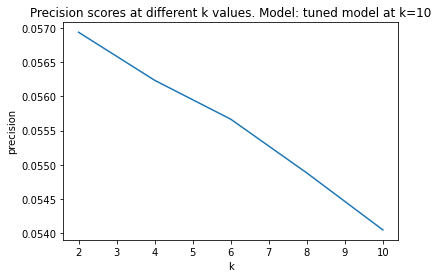

In [37]:
### Best hyperparameters to maximise precision_at_k score

# Experiment 2: low k-values
counter = 1
best_average_score_precision = 0
best_hyperparams_precision = None
best_model_precision = None
best_k = 0
for k in range(2, 11, 2):
    (score_precision, hyperparams_precision, model) = max(random_search_precision_at_k(k=k, train=train2, item_features = movies_csr, num_threads=1), key=lambda x: x[0])
    print("\nBest precision score at k={}: {}".format(k, score_precision))
    precision_score_array = []
    # After getting the best hyperparams for the model at a specific k, we see how its precision score changes as k changes
    for j in range(2, 11, 2):
        precision_score = precision_at_k(model, validation, train2, k=j, item_features=movies_csr, preserve_rows=False, num_threads=1, check_intersections=True).mean()
        precision_score_array.append(precision_score)
    ave_precision_score = sum(precision_score_array) / len(precision_score_array)
    if ave_precision_score > best_average_score_precision:
        best_average_score_precision = ave_precision_score
        best_hyperparams_precision = hyperparams_precision
        best_model_precision = model
        best_k = k
    print("Precision scores at k={}: {}".format(k, precision_score_array))
    plt.figure(counter)
    plt.plot(range(2, 11, 2), precision_score_array)
    plt.xlabel('k')
    plt.ylabel('precision')
    plt.title("Precision scores at different k values. Model: tuned model at k={}".format(k))
    plt.show
    counter+=1

print("\nBest highest average precision: {} \nBest k: {} \nBest hyperparams to maximise precision_at_k score: {}".format(best_average_score_precision, best_k, hyperparams_precision))

In [38]:
def random_search_recall_at_k(k, train, item_features, num_samples=num_samples_for_random_search, num_threads=1, cv=5):
    """
    Sample random hyperparameters, fit a LightFM model, and evaluate it
    on the test set.
    Parameters
    ----------
    train: np.float32 coo_matrix of shape [n_users, n_items]
        Training data.
    test: np.float32 coo_matrix of shape [n_users, n_items]
        Test data.
    num_samples: int, optional
        Number of hyperparameter choices to evaluate.

    Returns
    -------
    generator of (auc_score, hyperparameter dict, fitted model)
    """
    for i in range(cv):
        train2, validation = random_train_test_split(train, test_percentage=0.2)
        for hyperparams in itertools.islice(sample_hyperparameters(), num_samples):
            num_epochs = hyperparams.pop("num_epochs")

            model = LightFM(**hyperparams)
            model.fit(train2, epochs=num_epochs,item_features=item_features, num_threads=num_threads)

            score = recall_at_k(model, validation, train2, k=k, item_features=item_features, preserve_rows=False, num_threads=1, check_intersections=True).mean()

            hyperparams["num_epochs"] = num_epochs

            yield (score, hyperparams, model)


Best recall score at k=500: 0.43851403028628166
Recall scores at k=500: [0.4394205663076429, 0.5913592024739538, 0.7201534767563595, 0.8179538331023556, 0.8843968521992532]

Best recall score at k=1000: 0.5856928612174023
Recall scores at k=1000: [0.4304040613654465, 0.5895500403522994, 0.7159384156101225, 0.8166705563045759, 0.8801278388213434]

Best recall score at k=1500: 0.7185243173401441
Recall scores at k=1500: [0.43619072237187023, 0.5928028043534531, 0.7207388137953098, 0.8174212699492758, 0.8848675877224796]

Best recall score at k=2000: 0.8168062997731976
Recall scores at k=2000: [0.4343356776618188, 0.5886533416845017, 0.7210567117620337, 0.8172405019292411, 0.8883948860679187]

Best recall score at k=2500: 0.8858707346553626
Recall scores at k=2500: [0.4305472610556248, 0.5871858207586022, 0.7193675339296696, 0.8147820398569664, 0.8880824855954118]

Best highest average recall: 0.6906567861679129 
Best hyperparams to maximise recall_at_k score: {'no_components': 48, 'lear

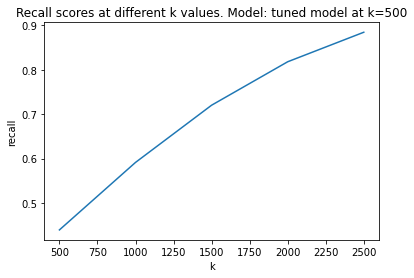

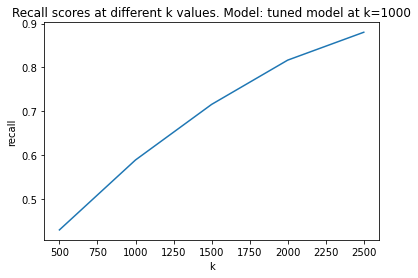

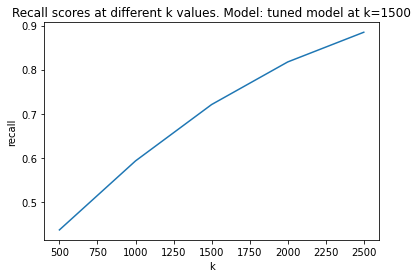

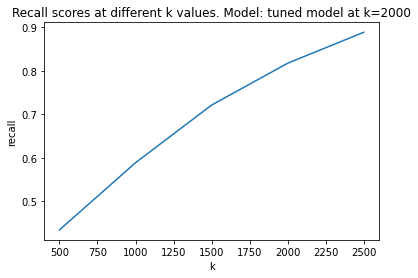

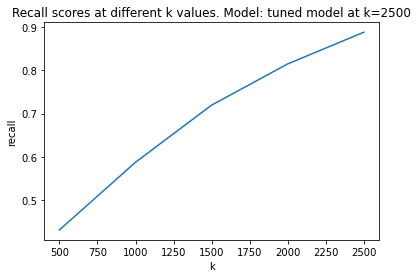

In [39]:
### Best hyperparameters to maximise recall_at_k score

counter = 1
best_average_score_recall = 0
best_hyperparams_recall = None
best_model_recall = None
for k in range(500, 2501, 500):
    (score_recall, hyperparams_recall, model) = max(random_search_recall_at_k(k=k, train=train2, item_features = movies_csr, num_threads=1), key=lambda x: x[0])
    print("\nBest recall score at k={}: {}".format(k, score_recall))
    recall_score_array = []
    # After getting the best hyperparams for the model at a specific k, we see how its recall score changes as k changes
    for j in range(500, 2501, 500):
        recall_score = recall_at_k(model, validation, train2, k=j, item_features=movies_csr, preserve_rows=False, num_threads=1, check_intersections=True).mean()
        recall_score_array.append(recall_score)
    ave_recall_score = sum(recall_score_array) / len(recall_score_array)
    if ave_recall_score > best_average_score_recall:
        best_average_score_recall = ave_recall_score
        best_hyperparams_recall = hyperparams_recall
        best_model_recall = model
    print("Recall scores at k={}: {}".format(k, recall_score_array))
    plt.figure(counter)
    plt.plot(range(500, 2501, 500), recall_score_array)
    plt.xlabel('k')
    plt.ylabel('recall')
    plt.title("Recall scores at different k values. Model: tuned model at k={}".format(k))
    plt.show
    counter+=1

print("\nBest highest average recall: {} \nBest hyperparams to maximise recall_at_k score: {}".format(best_average_score_recall, hyperparams_recall))

### Model Evaluation

In [40]:
def sample_recommendation_user(model, interactions, user_id, user_dict, 
                               item_dict,threshold = 0,nrec_items = 10, show = True):
    
    n_users, n_items = interactions.shape
    user_x = user_dict[user_id]
    scores = pd.Series(model.predict(user_x,np.arange(n_items), item_features=movies_csr))
    scores.index = interactions.columns
    scores = list(pd.Series(scores.sort_values(ascending=False).index))
    
    known_items = list(pd.Series(interactions.loc[user_id,:] \
                                 [interactions.loc[user_id,:] > threshold].index).sort_values(ascending=False))
    
    scores = [x for x in scores if x not in known_items]
    return_score_list = scores[0:nrec_items]
    known_items = list(pd.Series(known_items).apply(lambda x: item_dict[x]))
    scores = list(pd.Series(return_score_list).apply(lambda x: item_dict[x]))
    if show == True:
        print ("User: " + str(user_id))
        print("Known Likes:")
        counter = 1
        for i in known_items:
            print(str(counter) + '- ' + i)
            counter+=1

        print("\n Recommended Items:")
        counter = 1
        for i in scores:
            print(str(counter) + '- ' + i)
            counter+=1

In [41]:
users = list(ratings['user_id'])
random_user = random.choice(users)

### 1. Model that maximises AUC score

In [42]:
AUC_score = auc_score(model, test_interactions, train_interactions, item_features = movies_csr, num_threads=1).mean()
precision_k = precision_at_k(model, test_interactions, train_interactions, k=5, user_features=None, item_features=movies_csr, preserve_rows=False, num_threads=1, check_intersections=True).mean()
recall_k = recall_at_k(model, test_interactions, train_interactions, k=500, user_features=None, item_features=movies_csr, preserve_rows=False, num_threads=1, check_intersections=True).mean()
print("AUC Score: ", AUC_score, "\n")
print("Precision at k=", 5, ":", precision_k, "\n")
print("Recall at k=", 500, ":", recall_k, "\n")

sample_recommendation_user(model, user_movie_rating, random_user, user_dict, relevant_movie_dict)

AUC Score:  0.7066128 

Precision at k= 5 : 0.083553426 

Recall at k= 500 : 0.4333517823708068 

User: 5256
Known Likes:
1- Fantastic Voyage (1966)
2- Voyage to the Bottom of the Sea (1961)
3- Supergirl (1984)
4- Naked Gun 2 1/2: The Smell of Fear, The (1991)
5- Air America (1990)
6- F/X 2 (1992)
7- F/X (1986)
8- Patriot, The (2000)
9- Chicken Run (2000)
10- Serpico (1973)
11- Paper Chase, The (1973)
12- Soapdish (1991)
13- Nine 1/2 Weeks (1986)
14- Bird on a Wire (1990)
15- Mad Max Beyond Thunderdome (1985)
16- Mad Max 2 (a.k.a. The Road Warrior) (1981)
17- Mad Max (1979)
18- Alien Nation (1988)
19- Starman (1984)
20- Running Man, The (1987)
21- Predator 2 (1990)
22- Porky's Revenge (1985)
23- Porky's II: The Next Day (1983)
24- Porky's (1981)
25- Flatliners (1990)
26- Fabulous Baker Boys, The (1989)
27- Magnum Force (1973)
28- White Christmas (1954)
29- Blazing Saddles (1974)
30- American Gigolo (1980)
31- Moonraker (1979)
32- On Her Majesty's Secret Service (1969)
33- Honeymoon in 

### 2. Model that maximises precision_at_k score

In [43]:
AUC_score = auc_score(best_model_precision, test_interactions, train_interactions, item_features = movies_csr, num_threads=1).mean()
k = 5
precision_k = precision_at_k(best_model_precision, test_interactions, train_interactions, k=5, user_features=None, item_features=movies_csr, preserve_rows=False, num_threads=1, check_intersections=True).mean()
recall_k = recall_at_k(best_model_precision, test_interactions, train_interactions, k=500, user_features=None, item_features=movies_csr, preserve_rows=False, num_threads=1, check_intersections=True).mean()
print("AUC Score: ", AUC_score, "\n")
print("Precision at k=", 5, ":", precision_k, "\n")
print("Recall at k=", 500, ":", recall_k, "\n")

sample_recommendation_user(best_model_precision, user_movie_rating, random_user, user_dict, relevant_movie_dict)

AUC Score:  0.7095618 

Precision at k= 5 : 0.08259303 

Recall at k= 500 : 0.4413274892540938 

User: 5256
Known Likes:
1- Fantastic Voyage (1966)
2- Voyage to the Bottom of the Sea (1961)
3- Supergirl (1984)
4- Naked Gun 2 1/2: The Smell of Fear, The (1991)
5- Air America (1990)
6- F/X 2 (1992)
7- F/X (1986)
8- Patriot, The (2000)
9- Chicken Run (2000)
10- Serpico (1973)
11- Paper Chase, The (1973)
12- Soapdish (1991)
13- Nine 1/2 Weeks (1986)
14- Bird on a Wire (1990)
15- Mad Max Beyond Thunderdome (1985)
16- Mad Max 2 (a.k.a. The Road Warrior) (1981)
17- Mad Max (1979)
18- Alien Nation (1988)
19- Starman (1984)
20- Running Man, The (1987)
21- Predator 2 (1990)
22- Porky's Revenge (1985)
23- Porky's II: The Next Day (1983)
24- Porky's (1981)
25- Flatliners (1990)
26- Fabulous Baker Boys, The (1989)
27- Magnum Force (1973)
28- White Christmas (1954)
29- Blazing Saddles (1974)
30- American Gigolo (1980)
31- Moonraker (1979)
32- On Her Majesty's Secret Service (1969)
33- Honeymoon in V

### 3. Model that maximises recall_at_k score

In [44]:
AUC_score = auc_score(best_model_recall, test_interactions, train_interactions, item_features = movies_csr, num_threads=1).mean()
k = 5
precision_k = precision_at_k(best_model_recall, test_interactions, train_interactions, k=5, user_features=None, item_features=movies_csr, preserve_rows=False, num_threads=1, check_intersections=True).mean()
recall_k = recall_at_k(best_model_recall, test_interactions, train_interactions, k=500, user_features=None, item_features=movies_csr, preserve_rows=False, num_threads=1, check_intersections=True).mean()
print("AUC Score: ", AUC_score, "\n")
print("Precision at k=", 5, ":", precision_k, "\n")
print("Recall at k=", 500, ":", recall_k, "\n")

sample_recommendation_user(best_model_recall, user_movie_rating, random_user, user_dict, relevant_movie_dict)

AUC Score:  0.70836186 

Precision at k= 5 : 0.0847539 

Recall at k= 500 : 0.442515008803908 

User: 5256
Known Likes:
1- Fantastic Voyage (1966)
2- Voyage to the Bottom of the Sea (1961)
3- Supergirl (1984)
4- Naked Gun 2 1/2: The Smell of Fear, The (1991)
5- Air America (1990)
6- F/X 2 (1992)
7- F/X (1986)
8- Patriot, The (2000)
9- Chicken Run (2000)
10- Serpico (1973)
11- Paper Chase, The (1973)
12- Soapdish (1991)
13- Nine 1/2 Weeks (1986)
14- Bird on a Wire (1990)
15- Mad Max Beyond Thunderdome (1985)
16- Mad Max 2 (a.k.a. The Road Warrior) (1981)
17- Mad Max (1979)
18- Alien Nation (1988)
19- Starman (1984)
20- Running Man, The (1987)
21- Predator 2 (1990)
22- Porky's Revenge (1985)
23- Porky's II: The Next Day (1983)
24- Porky's (1981)
25- Flatliners (1990)
26- Fabulous Baker Boys, The (1989)
27- Magnum Force (1973)
28- White Christmas (1954)
29- Blazing Saddles (1974)
30- American Gigolo (1980)
31- Moonraker (1979)
32- On Her Majesty's Secret Service (1969)
33- Honeymoon in Ve